In [ ]:
# Carrega os pacotes
import xarray as xr
!pip install cartopy # Necessário no Google Colab
import cartopy.crs as ccrs
from cartopy.io.shapereader import Reader
from matplotlib import pyplot as plt

In [ ]:
# Download do contorno de estados
!wget -nc https://naturalearth.s3.amazonaws.com/10m_cultural/ne_10m_admin_1_states_provinces.zip
!unzip -u ne_10m_admin_1_states_provinces.zip
states = list(Reader('ne_10m_admin_1_states_provinces.shp').geometries())

In [ ]:
# Abertura dos arquivos
obs = xr.open_dataset('observation.nc')      # Observação
prev = xr.open_dataset('forecast.nc')-273.15 # Previsão em K convertendo pra oC
prev_int = prev.interp_like(obs)             # Interpola previsão para coordenadas da observação

In [ ]:
# Cálculo do RMSE
err_sqrd = (prev_int['t2m'] - obs['temperatura'])**2  # Quadrado do erro #time=72
mean6h_err_sqrd = err_sqrd.resample(time="6H").mean() # Média a cada 6 horas #time=12
rmse = mean6h_err_sqrd**0.5                           # Raiz quadrada

rmse.to_netcdf('rmse_6h.nc')                          # RMSE vai para um arquivo .nc

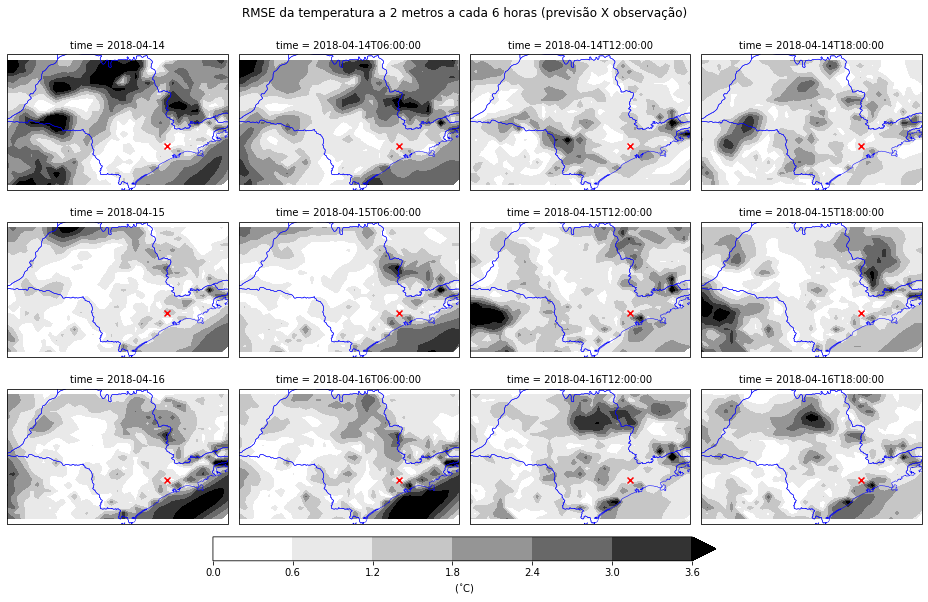

In [ ]:
# Mapas a cada 6 horas
p = rmse.plot.contourf(             # Mapa com contorno preenchido
    transform=ccrs.PlateCarree(),   # Projeção do dado
    subplot_kws=dict(projection=ccrs.PlateCarree()), # Projeção a ser plotada
    col="time", col_wrap=4,         # 4 colunas, 1 p/ 6h, 1 linha p/ dia
    cmap = 'Greys',                 # Mapa de cores
    cbar_kwargs=dict(orientation='horizontal', shrink= 0.55, pad=0.02, label='($^{\circ}$C)'), # Parâmetros da escala
    robust=True)                    # Escala entre percentis 2 e 98

for ax in p.axes.flat:              # Aplica opções em todos os mapas
  ax.add_geometries(states, ccrs.PlateCarree(), edgecolor='b',facecolor='none', linewidth=0.5) # Contorno dos estados
  ax.scatter(x=-46.6388, y=-23.5489, marker='x', color='r', transform=ccrs.PlateCarree())      # Marca cidade de São Paulo
  ax.set_ylabel('Longitude')

plt.suptitle('RMSE da temperatura a 2 metros a cada 6 horas (previsão X observação)') # Título
plt.savefig('RMSE_mapas_6h.png')    # Salva a figura

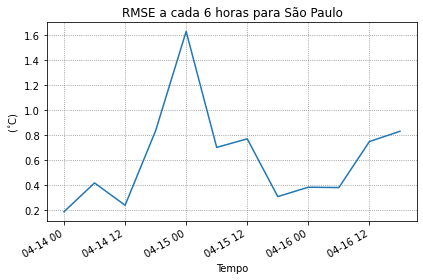

In [ ]:
# Gráfico para a cidade de São Paulo
saopaulo = rmse.sel(lon=-46.6388, lat=-23.5489, method='nearest') # Coordenadas do ponto
saopaulo.plot.line(x="time")          # Gráfico de linha variando no tempo
plt.grid(color='gray', linestyle=':') # Grade ao fundo
plt.xlabel("Tempo")                   # Nome eixo x
plt.ylabel("($^{\circ}$C)")           # Nome eixo y
plt.tight_layout()                    # Ajusta o gráfico na figura
plt.title('RMSE a cada 6 horas para São Paulo') # Título
plt.savefig('RMSE_SP_6h.png')         # Salva a figura